In [1]:
import re
import emoji
import contractions
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
from nltk.tokenize import word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\veni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#pip install contractions

In [4]:
#pip install emoji

In [5]:
df=pd.read_csv("tweet_data.csv")

In [6]:
df.shape

(18727, 3)

In [7]:
Sentiment_count=df.sentiment.value_counts()

([<matplotlib.patches.Wedge at 0x71f1cfbaf0>,
 [Text(-0.09831704680235924, 1.095597443547612, 'positive'),
  Text(0.09831704680235935, -1.095597443547612, 'negative')],
 [Text(-0.053627480074014126, 0.5975986055714246, '52.8'),
  Text(0.05362748007401418, -0.5975986055714246, '47.2')])

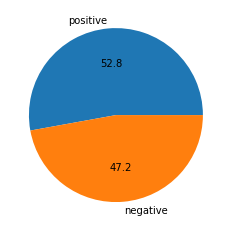

In [8]:
plt.pie(Sentiment_count.values,labels=Sentiment_count.index,autopct="%1.1f")

In [9]:
positive_tweets=df[df["sentiment"]=="positive"]["tweet_text"]
negative_tweets=df[df["sentiment"]=="negative"]["tweet_text"]
neg_tweets="".join(sentiment.lower() for sentiment in negative_tweets)
pos_tweet="".join(sentiment.lower() for sentiment in positive_tweets)
pos_word_cloud=WordCloud().generate(pos_tweet)
neg_word_cloud=WordCloud().generate(neg_tweets)

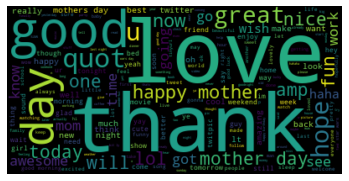

In [10]:
plt.imshow(pos_word_cloud,interpolation="bilinear")
plt.axis("off")
plt.show()

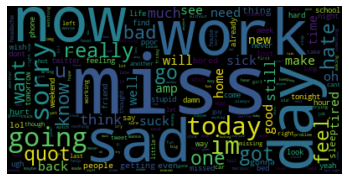

In [11]:
plt.imshow(neg_word_cloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
le = LabelEncoder()
le.fit(df["sentiment"])
df["labeled_output"]=le.transform(df["sentiment"])

In [13]:
def replace_tweet(tweet,default_replace=""):
    tweet=re.sub('RT\s+',default_replace,tweet)
    return tweet

def replace_user(tweet,default_replace="twitteruser"):
    tweet=re.sub('\B @ \W+',default_replace,tweet)
    return tweet
                 
def demojize(tweet):
    tweet=emoji.demojize(tweet)
    return tweet
                 
def replace_url(tweet,default_replace=""):
    tweet=re.sub('(http|https):\/\/\S+',default_replace,tweet)
    return tweet
        
def replace_hashtag(tweet,default_replace="twitteruser"):
    tweet=re.sub('#+',default_replace,tweet)
    return tweet
        
def lowercas(tweet):
    tweet=tweet.lower()
    return tweet

def word_repetition(tweet):
    tweet=re.sub(r'(.)1+', r'\1\1',tweet)
    return tweet

def punct_repetion(tweet,default_replace=""):
    tweet=re.sub(r'[\?\.\!]+(?=[\?\.\!])',default_replace,tweet)
    return tweet

def fix_contraction(tweet):
    tweet=contractions.fix(tweet)
    return tweet

def tokenize(tweet):
    tokens=word_tokenize(tweet)
    return tokens

In [14]:
df["tweet_text"]=df["tweet_text"].apply(lambda x : replace_tweet(x,default_replace=""))
df["tweet_text"]=df["tweet_text"].apply(lambda x : replace_user(x,default_replace=""))
df["tweet_text"]=df["tweet_text"].apply(lambda x : demojize(x))
df["tweet_text"]=df["tweet_text"].apply(lambda x : replace_url(x,default_replace=""))
df["tweet_text"]=df["tweet_text"].apply(lambda x : replace_hashtag(x,default_replace="twitteruser"))
df["tweet_text"]=df["tweet_text"].apply(lambda x : lowercas(x))
df["tweet_text"]=df["tweet_text"].apply(lambda x : word_repetition(x))
df["tweet_text"]=df["tweet_text"].apply(lambda x : punct_repetion(x,default_replace=""))
df["tweet_text"]=df["tweet_text"].apply(lambda x : fix_contraction(x))


In [15]:
def custom_tokenize(tweet,keep_punct=False,keep_alnum=False,keep_stop=False):
    token_list=word_tokenize(tweet)
    
    if not keep_punct:
        token_list=[token for token in token_list if token not in string.punctuation]
        
    if not keep_alnum:
        token_list=[token for token in token_list if token.isalpha()]
        
    if not keep_stop:
        stop_words=set(stopwords.words("english"))
        stop_words.discard("not")
        token_list=[token for token in token_list if token not in stop_words]
        
        return token_list

In [16]:
df["tokenized_tweet_text"]=df["tweet_text"].apply(lambda x : custom_tokenize(x))

In [17]:
PS = PorterStemmer()
LS = LancasterStemmer()
SBS = SnowballStemmer("english")

In [18]:
def tok_stem(tokens,stemmer):
    token_list=[]
    for token in tokens:
        token_list.append(stemmer.stem(token))
    return token_list

In [19]:
df["PorterStemmer_tweeted_text"]=df["tokenized_tweet_text"].apply(lambda x : tok_stem(x,PS))
df["LancasterStemmer_tweeted_text"]=df["tokenized_tweet_text"].apply(lambda x : tok_stem(x,LS))
df["SnowballStemmer_tweeted_text"]=df["tokenized_tweet_text"].apply(lambda x : tok_stem(x,SBS))

In [20]:
from nltk.corpus import wordnet
nltk.download("wordnet")
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\veni\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
LMR=WordNetLemmatizer()

In [22]:
def lemmatize_token(tokens,lemmatizer):
    token_list=[]
    tagged_token=[]
    for token in tokens:
        token_list.append(lemmatizer.lemmatize(token))
    return token_list
    

In [23]:
df["lemmatized_tweeted_text"]=df["tokenized_tweet_text"].apply(lambda x : lemmatize_token(x,LMR))

In [24]:
def word_tag(tokens,word_type):
    tag=word_type(tokens)
    return tag

In [25]:
df["word_tag"]=df["tokenized_tweet_text"].apply(lambda x : word_tag(x,nltk.pos_tag)) 

In [26]:
new_data=pd.concat([df["lemmatized_tweeted_text"],df["labeled_output"]],axis=1)

In [27]:
new_data.labeled_output.dtype

dtype('int32')

In [28]:
x=new_data.lemmatized_tweeted_text.tolist()
y=new_data.labeled_output.tolist()

In [29]:
# count vectorizer
def fit_cv(tweet_corpus):
  cv_vect = CountVectorizer(tokenizer=lambda x: x,
                            preprocessor=lambda x: x)
  cv_vect.fit(tweet_corpus)
  return cv_vect


In [30]:
# Term Frequency – Inverse Document Frequency (TF-IDF)
def fit_tfidf(tweet_corpus):
  tf_vect = TfidfVectorizer(preprocessor=lambda x: x,tokenizer=lambda x: x)
  tf_vect.fit(tweet_corpus)
  return tf_vect

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x, y,random_state=0,test_size=0.20)

In [32]:
def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model

In [33]:
# count vectorizer
cv = fit_cv(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [34]:
model_lr_cv = fit_lr(X_train_cv, y_train)

In [35]:
y_pred_lr_cv = model_lr_cv.predict(X_test_cv)

In [36]:
print("Logistic Regression Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_cv)))

Logistic Regression Model Accuracy: 88.60%


In [37]:
#TFIDF
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [38]:
model_lr_tf = fit_lr(X_train_tf, y_train)

In [39]:
y_pred_lr_tf = model_lr_tf.predict(X_test_tf)

In [40]:
print("Logistic Regression Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_tf)))

Logistic Regression Model Accuracy: 88.73%
